In [1]:
%load_ext autoreload
%autoreload 2
    
import os, sys
#PWD = os.getenv('PWD')
PWD = '/Users/chris/Documents/lab/emAnalysis/backend/server'

PROJ_MISSING_MSG = """Set an enviroment variable:\n
`DJANGO_PROJECT=your_project_name`\n
or call:\n
`init_django(your_project_name)`
"""

def init_django(project_name=None):
    os.chdir(PWD)
    project_name = project_name or os.environ.get('DJANGO_PROJECT') or None
    if project_name == None:
        raise Exception(PROJ_MISSING_MSG)
    sys.path.insert(0, os.getenv('PWD'))
    os.environ.setdefault('DJANGO_SETTINGS_MODULE', f'{project_name}.settings')
    os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"
    import django
    django.setup()

init_django("server")
from django.conf import settings
media_root = settings.MEDIA_ROOT
import numpy as np
import os
from matplotlib import pyplot as plt
import functools
import math
import sims
import copy
import cv2
import os
from pathlib import Path
import numpy as np
from skimage.measure import regionprops
from scipy import spatial
import pickle
from matplotlib.figure import Figure
import pyvips
from core.models import Canvas
from mims.models import MIMSImage, MIMSImageSet
from PIL import Image
from scipy.ndimage import rotate
import pprint
import sims
import SimpleITK as sitk
import tifffile

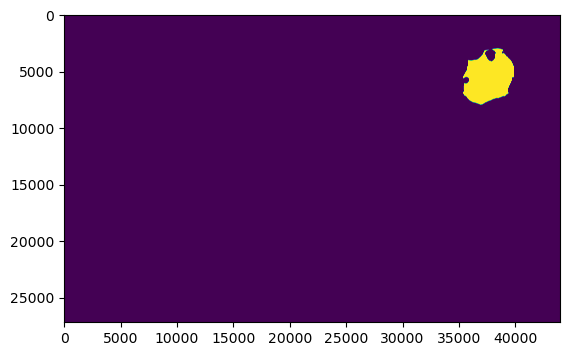

In [2]:
canvas = Canvas.objects.get(id="f5c084c9-4fec-47a2-a3f4-340ecf1e94bc")
imageset = canvas.mims_sets.first()
cell_path = Path(
  os.path.join(settings.MEDIA_ROOT, "mims_image_sets", str(imageset.id), "composites", "cells.tiff")
)
nuclei_path = Path(
  os.path.join(settings.MEDIA_ROOT, "mims_image_sets", str(imageset.id), "composites", "nuclei.tiff")
)
def scale_to_uint8(arr):
    # Find the min and max values
    arr_min = arr.min()
    arr_max = arr.max()
    
    # Scale to [0, 1]
    scaled = (arr - arr_min) / (arr_max - arr_min)
    
    # Scale to [0, 255] and convert to uint8
    uint8_scaled = (scaled * 255).astype(np.uint8)
    
    return uint8_scaled
img_cells = np.array(Image.open(cell_path))
img_nuclei = np.array(Image.open(nuclei_path))
img_nuclei = img_nuclei > 0

img_em = np.array(Image.open(canvas.images.first().image.file))
def show_cell(cell_num):
    cell_mask = img_cells == cell_num
    plt.imshow(cell_mask)
    plt.show()
show_cell(1)

In [3]:
img_32s = np.array(Image.open(Path(
  os.path.join(settings.MEDIA_ROOT, "mims_image_sets", str(imageset.id), "composites", "unwarped_isotopes", "32S.tiff")
)))
img_se = np.array(Image.open(Path(
  os.path.join(settings.MEDIA_ROOT, "mims_image_sets", str(imageset.id), "composites", "unwarped_isotopes", "SE.tiff")
)))

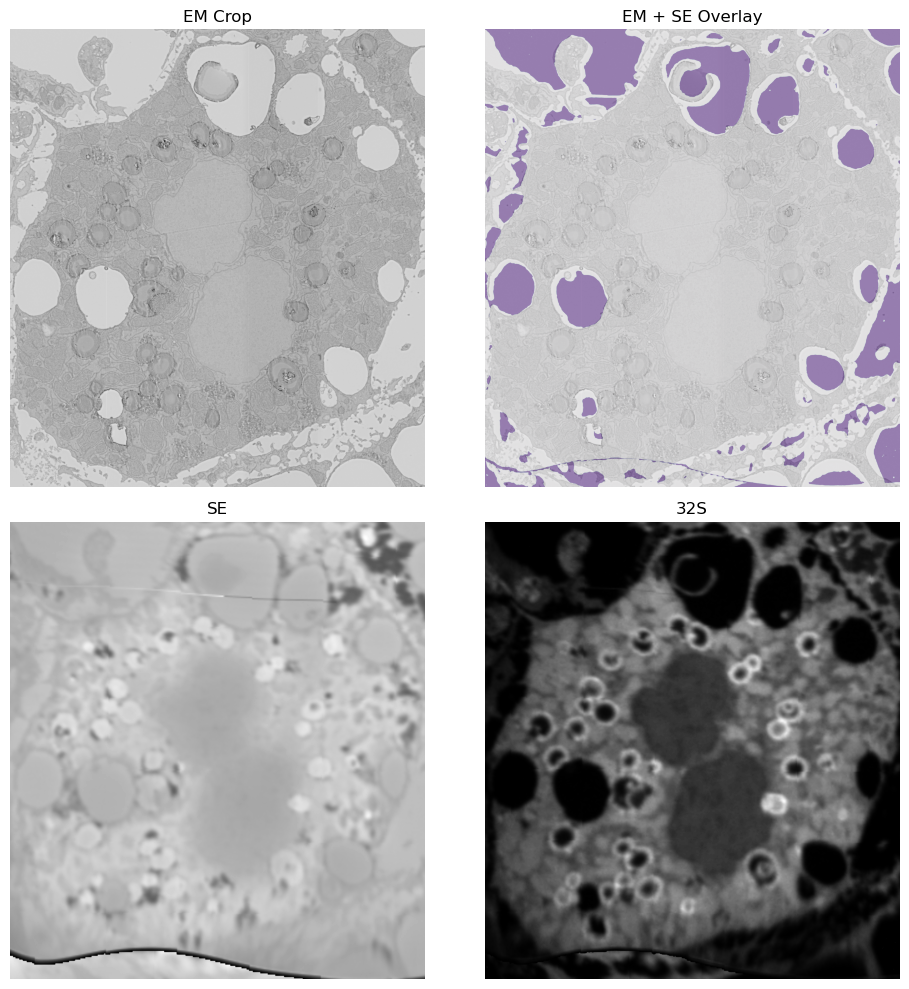

(35356, 2940, 39897, 7951)

In [7]:
def show_cell(cell_num):
    cell_mask = img_cells == cell_num

    # Find the bounding box
    rows = np.any(cell_mask, axis=1)
    cols = np.any(cell_mask, axis=0)
    ymin, ymax = np.where(rows)[0][[0, -1]]
    xmin, xmax = np.where(cols)[0][[0, -1]]

    # Crop to the bounding box
    em_crop = img_em[ymin:ymax+1, xmin:xmax+1]
    img_se_crop = img_se[ymin:ymax+1, xmin:xmax+1]
    img_32s_crop = img_32s[ymin:ymax+1, xmin:xmax+1]

    img_32s_crop = np.where(img_32s_crop == 0, 110, img_32s_crop)
    img_se_crop = np.where(img_se_crop == 0, 110, img_se_crop)
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))

    # Display the EM image on the first subplot
    axes[0, 0].imshow(em_crop, cmap='gray')
    axes[0, 0].set_title("EM Crop")
    axes[0, 0].axis("off")

    # Overlay SE image on the EM image with transparency in the second subplot
    axes[0, 1].imshow(em_crop, cmap='gray')
    img_32s_overlay = img_32s_crop < 25
    axes[0, 1].imshow(img_32s_overlay, cmap='Purples', alpha=0.4)
    axes[0, 1].set_title("EM + SE Overlay")
    axes[0, 1].axis("off")

    # Display SE and 32S images on the lower row subplots
    axes[1, 0].imshow(img_se_crop, cmap='gray')
    axes[1, 0].set_title("SE")
    axes[1, 0].axis("off")

    axes[1, 1].imshow(img_32s_crop, cmap='gray')
    axes[1, 1].set_title("32S")
    axes[1, 1].axis("off")

    # Show the figure with all subplots
    plt.tight_layout()
    plt.show()

    # Return the bounding box coordinates
    return (xmin, ymin, xmax, ymax)

# Call the function with the desired cell number
show_cell(1)
